## Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.feature_selection import f_regression, RFE
from sklearn.feature_selection import SelectKBest

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from scipy.stats import boxcox
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold,cross_val_score

import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_columns',None)
pd.set_option('precision',3)

In [2]:
agri_data = pd.read_excel('Saha_et_al_2020_ERL_Data.xlsx',sheet_name=1)
agri_data.head()

,Date,Year,Experiment,DataUse,Replication,Month,Vegetation,VegType,N2O,N_rate,PP2,PP7,AirT,DAF_TD,DAF_SD,WFPS25cm,NH4,NO3,Clay,Sand,SOM
0,2012-02-09,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.897,170,0.00,0.00,-2.0,276,241,0.667,11.046,22.941,62.5,637.5,1.174
1,2012-02-10,2012,BCSE_KBS,Building,R1,February,Corn,Annual,2.190,170,0.00,0.00,-2.4,277,242,0.641,11.008,22.960,62.5,637.5,1.174
2,2012-02-18,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.543,170,3.30,8.64,0.3,285,250,0.728,10.832,23.222,62.5,637.5,1.174
3,2012-02-19,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.343,170,0.00,8.13,-3.8,286,251,0.687,10.850,23.272,62.5,637.5,1.174
4,2012-03-16,2012,BCSE_KBS,Building,R1,March,Corn,Annual,2.948,170,1.02,8.39,17.6,312,277,0.716,10.205,24.207,62.5,637.5,1.174


## EDA

In [3]:
agri_data.shape

(2246, 21)

In [4]:
agri_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2246 entries, 0 to 2245
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2246 non-null   datetime64[ns]
 1   Year         2246 non-null   int64         
 2   Experiment   2246 non-null   object        
 3   DataUse      2246 non-null   object        
 4   Replication  2246 non-null   object        
 5   Month        2246 non-null   object        
 6   Vegetation   2246 non-null   object        
 7   VegType      2246 non-null   object        
 8   N2O          2246 non-null   float64       
 9   N_rate       2246 non-null   int64         
 10  PP2          2246 non-null   float64       
 11  PP7          2246 non-null   float64       
 12  AirT         2246 non-null   float64       
 13  DAF_TD       2246 non-null   int64         
 14  DAF_SD       2246 non-null   int64         
 15  WFPS25cm     2194 non-null   float64       
 16  NH4   

In [5]:
agri_data.describe(include='O').T

,count,unique,top,freq
Experiment,2246,3,BCSE_KBS,1094
DataUse,2246,2,Building,1576
Replication,2246,5,R1,1350
Month,2246,12,July,285
Vegetation,2246,3,Corn,1845
VegType,2246,1,Annual,2246


In [6]:
agri_data.describe(include=['int64','float64']).apply(lambda x: x.apply(lambda x: format(x,'g'))).T

,count,mean,std,min,25%,50%,75%,max
Year,2246,2011.93,3.61742,2002,2011,2013,2014,2017
N2O,2246,7.46861,28.4883,-7.4153,0.504316,1.97206,5.18762,593.072
N_rate,2246,142.994,56.1304,0,135,170,170,213
PP2,2246,5.21984,10.0641,0,0,0.51,6,95.25
PP7,2246,19.2453,23.7234,0,3.56,11.93,27,260.09
AirT,2246,12.4087,9.49015,-20.7,5.94,14.49,20.07,30.7
DAF_TD,2246,195.321,144.915,1,73.25,160,308.75,718
DAF_SD,2246,198.898,142.907,0,75,172,320,678
WFPS25cm,2194,0.531047,0.171868,0.0243877,0.390203,0.553853,0.680321,0.912113
NH4,2170,11.4514,13.2149,1.38339,5.29032,9.08128,12.1403,228.525


In [7]:
agri_data_train, agri_data_test = train_test_split(agri_data, test_size=0.3, random_state=19)

In [8]:
print('Train Data Shape: ',agri_data_train.shape)
print('Test Data Shape: ',agri_data_test.shape)

Train Data Shape:  (1572, 21)
Test Data Shape:  (674, 21)


In [9]:
agri_data_train.isna().sum()[agri_data_train.isna().sum() > 0]

WFPS25cm    38
NH4         54
NO3         21
dtype: int64

In [10]:
agri_data_test.isna().sum()[agri_data_test.isna().sum() > 0]

WFPS25cm    14
NH4         22
NO3          9
dtype: int64

In [11]:
null_cols = [col for col in agri_data.columns if agri_data[col].isna().sum() > 0 ]
null_cols

['WFPS25cm', 'NH4', 'NO3']

In [12]:
imputer = KNNImputer()
agri_data_train[null_cols] = imputer.fit_transform(agri_data_train[null_cols])
agri_data_test[null_cols]  = imputer.transform(agri_data_test[null_cols])

In [13]:
agri_data_train.isna().sum()[agri_data_train.isna().sum() > 0]

Series([], dtype: int64)

In [14]:
agri_data_test.isna().sum()[agri_data_test.isna().sum() > 0]

Series([], dtype: int64)

In [15]:
num_cols = [col for col in agri_data_train.columns if agri_data_train[col].dtype in ['int64','float64']]
cat_cols = [col for col in agri_data_train.columns if agri_data_train[col].dtype=='object']

In [16]:
num_cols

['Year',
 'N2O',
 'N_rate',
 'PP2',
 'PP7',
 'AirT',
 'DAF_TD',
 'DAF_SD',
 'WFPS25cm',
 'NH4',
 'NO3',
 'Clay',
 'Sand',
 'SOM']

In [17]:
cat_cols

['Experiment', 'DataUse', 'Replication', 'Month', 'Vegetation', 'VegType']

## Univariate Analysis

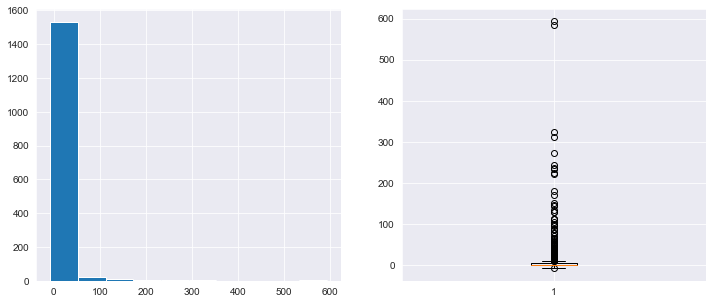

In [18]:
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
ax1.hist(agri_data_train['N2O'])
ax2.boxplot(agri_data_train['N2O'])
plt.show()

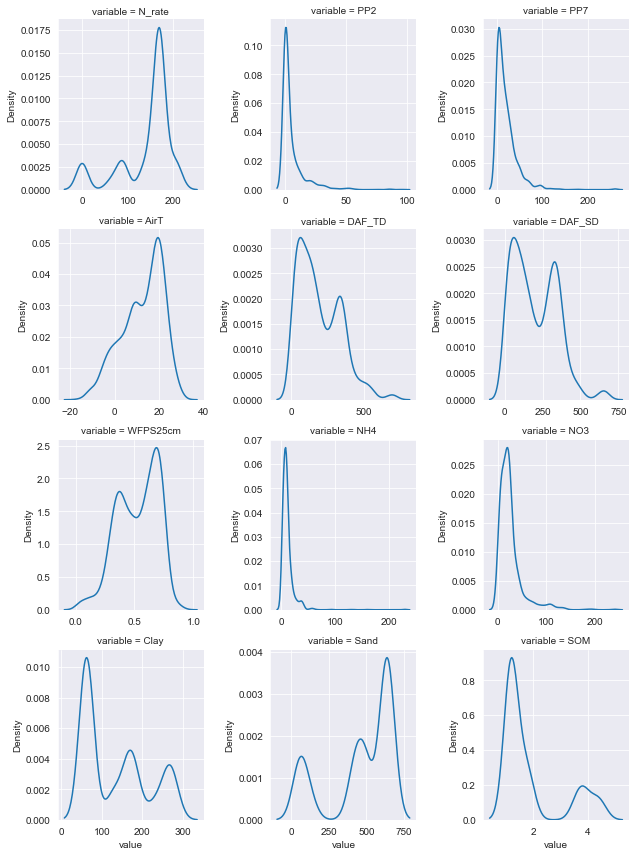

In [19]:
unpivot = pd.melt(agri_data_train,id_vars='N2O',value_vars=num_cols[2:])

g = sns.FacetGrid(unpivot, col='variable',col_wrap=3, sharex=False, sharey=False)
g.map(sns.kdeplot,'value')
plt.show()

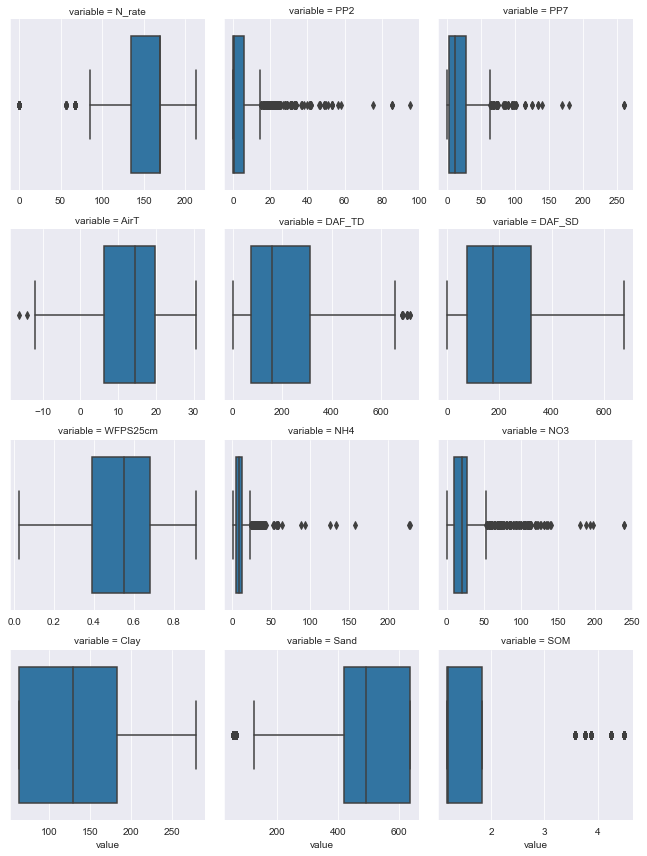

In [20]:
unpivot = pd.melt(agri_data_train, id_vars='N2O',value_vars=num_cols[2:])
g = sns.FacetGrid(unpivot, col='variable', col_wrap=3, sharex=False, sharey=False)
g.map(sns.boxplot,'value')
plt.show()

## Multi Variate Analysis

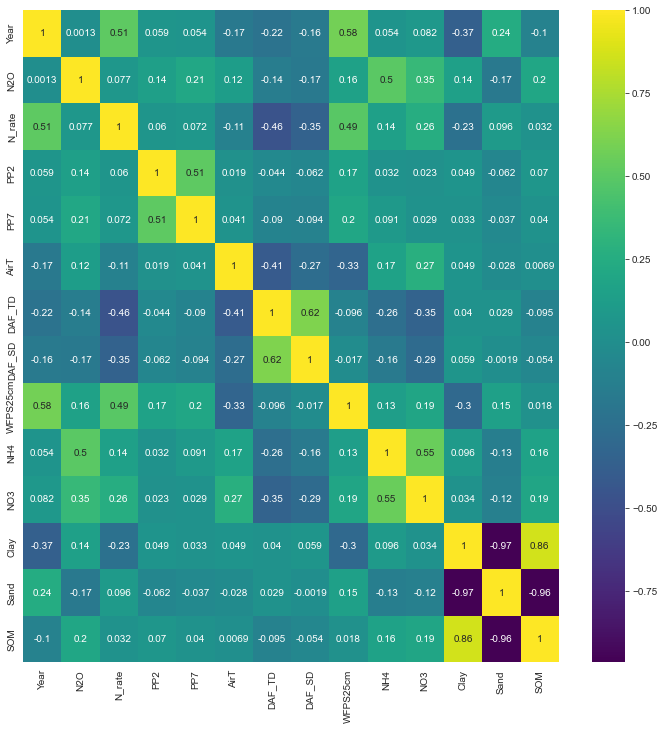

In [21]:
plt.figure(figsize=(12,12))
sns.heatmap(agri_data_train.corr(), annot=True,cmap='viridis')
plt.show()

<Figure size 864x504 with 0 Axes>

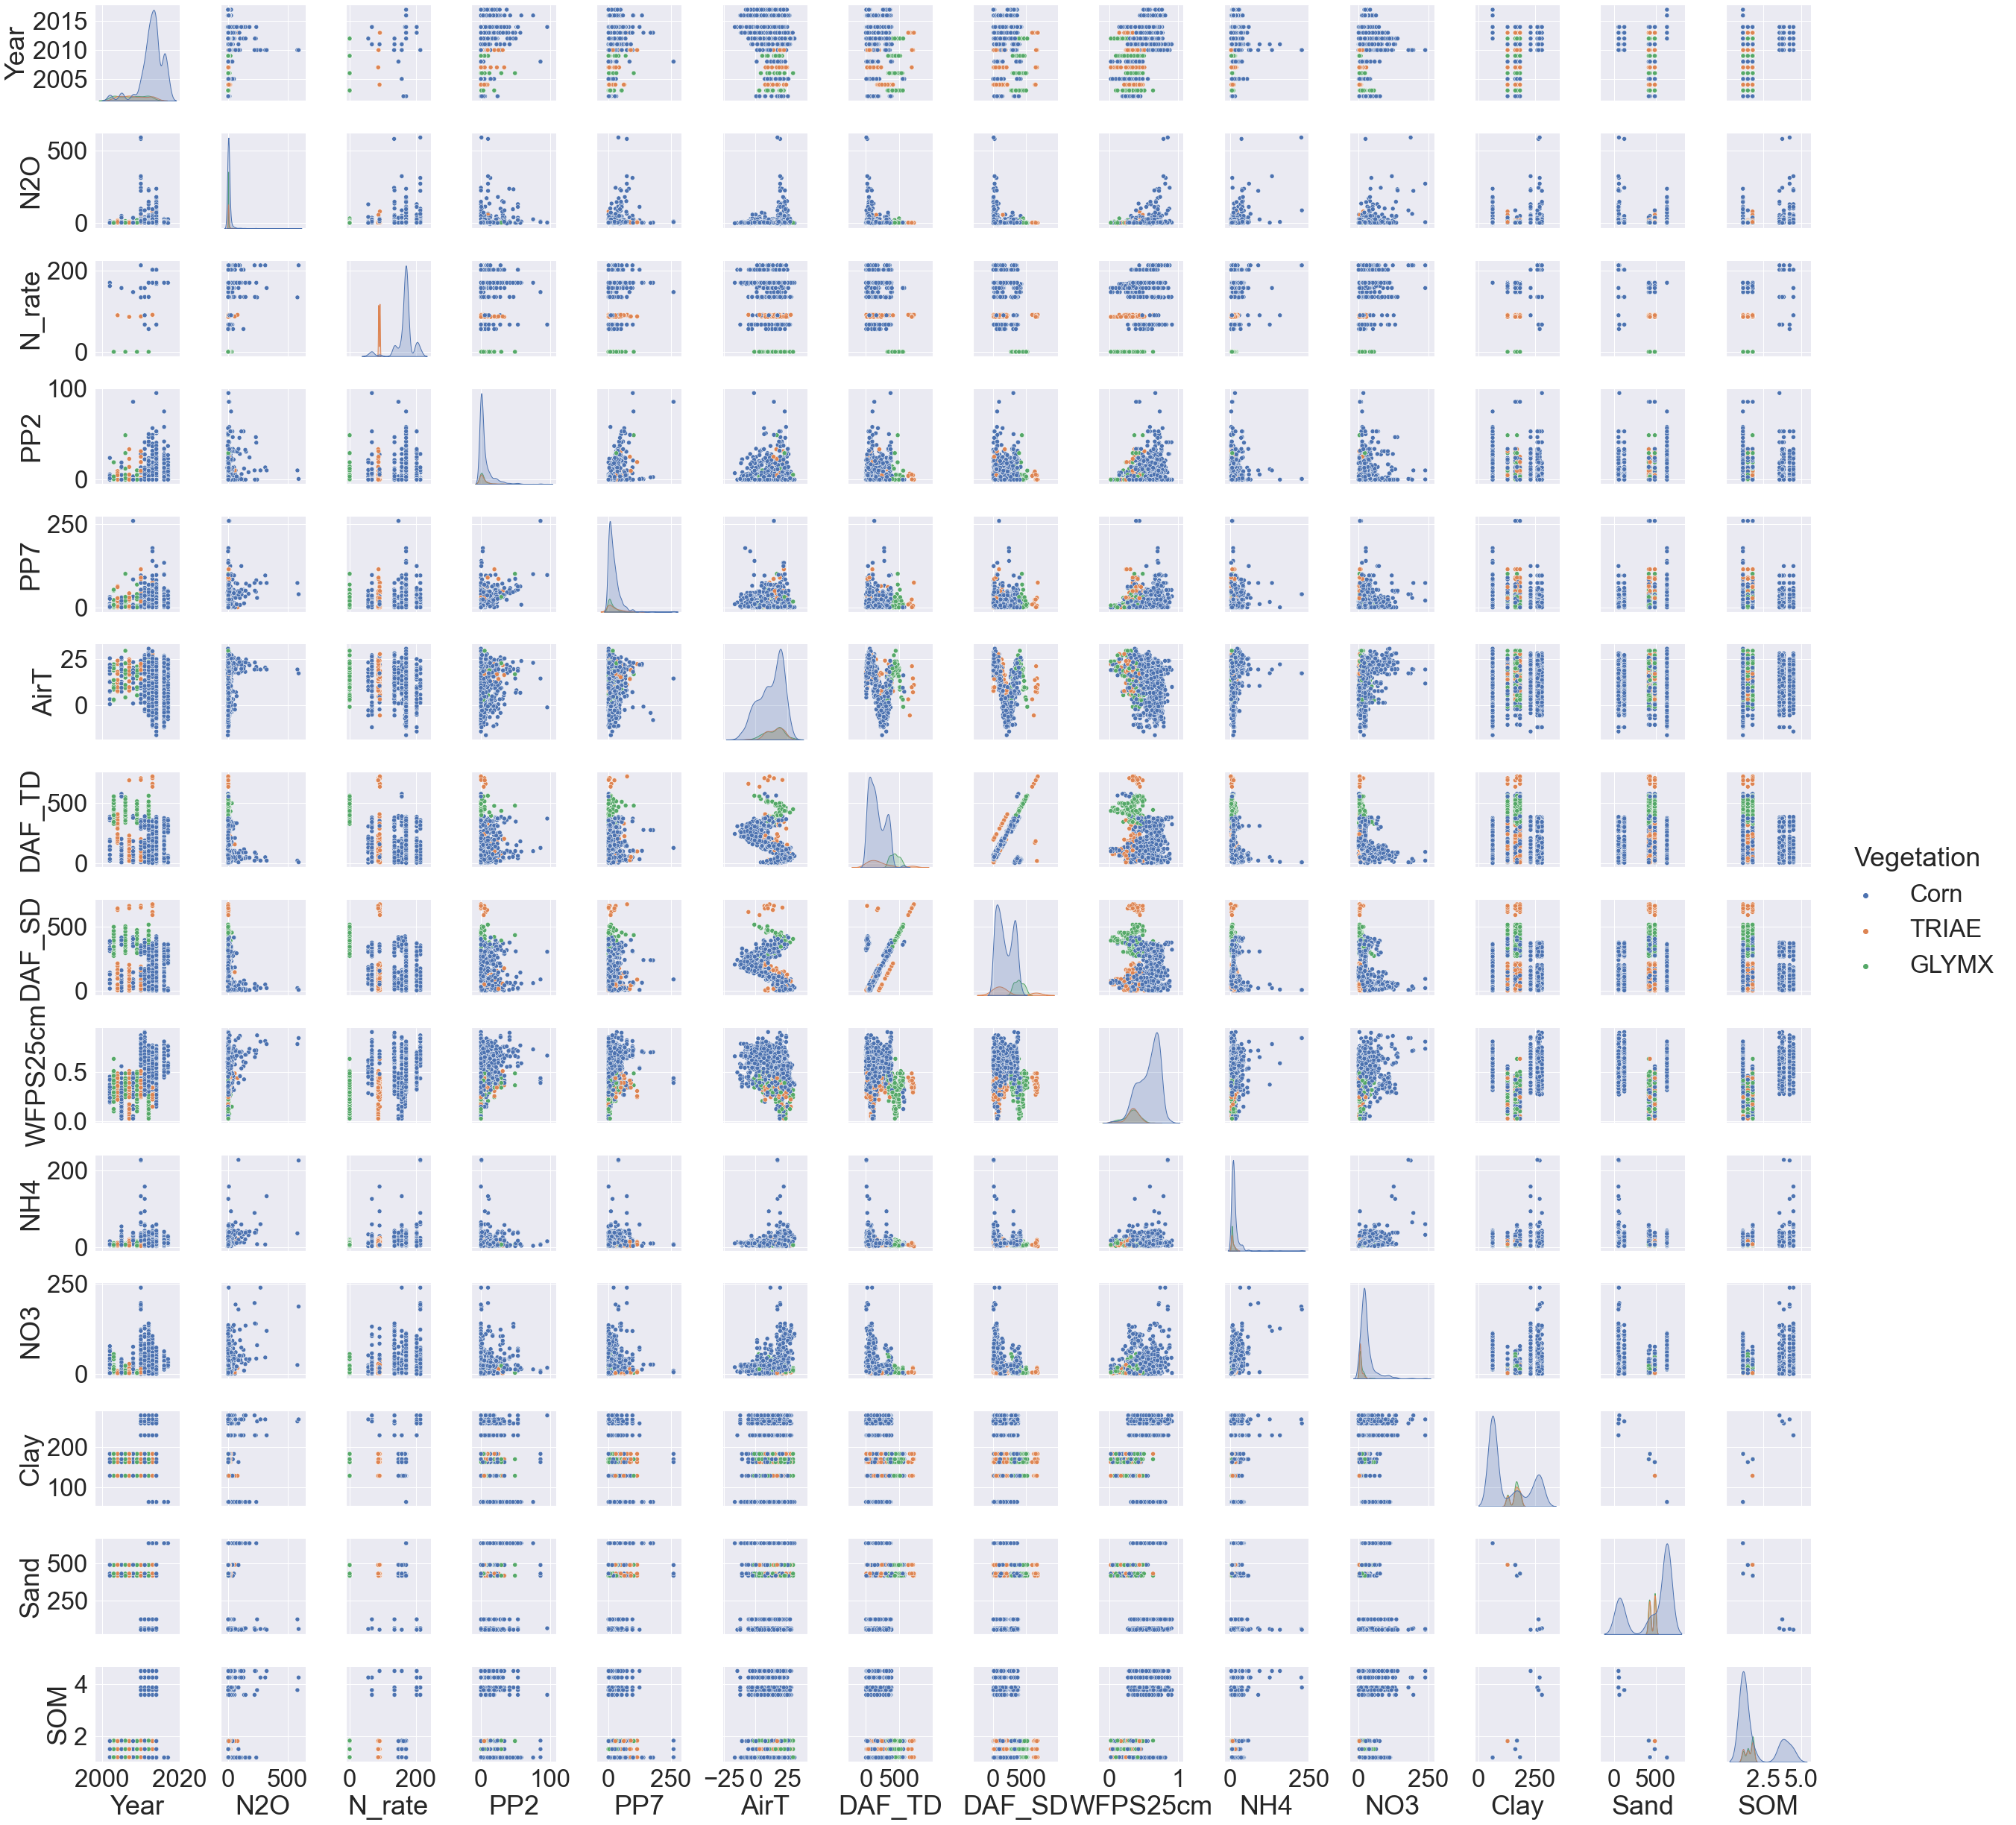

In [24]:
plt.figure(figsize=(12,7))
sns.set(font_scale=3)
sns.pairplot(agri_data_train,hue='Vegetation')
plt.show()

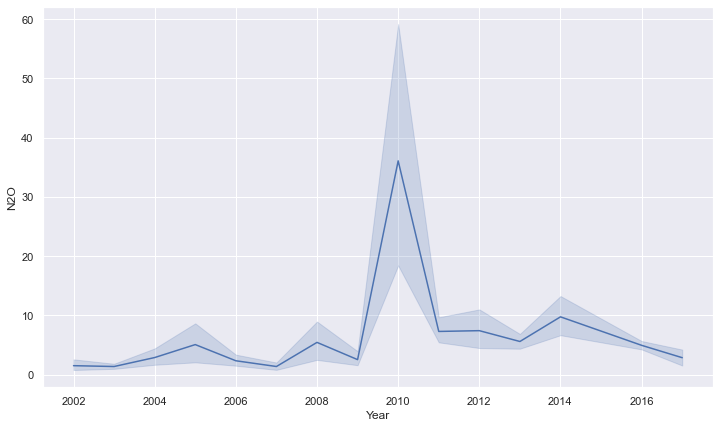

In [27]:
plt.figure(figsize=(12,7))
sns.set(font_scale=1)
sns.lineplot(x = agri_data_train['Year'],y = agri_data_train['N2O'])
plt.show()

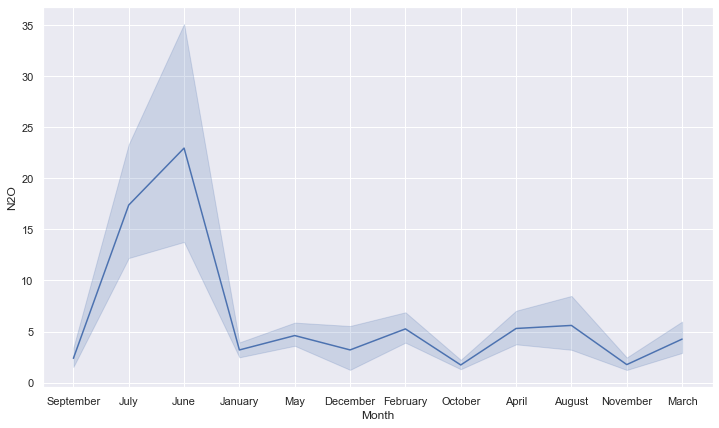

In [28]:
plt.figure(figsize=(12,7))
sns.lineplot(x=agri_data_train['Month'], y = agri_data_train['N2O'])
plt.show()

In [29]:
from scipy import stats

z = np.abs(stats.zscore(agri_data_train[num_cols]))
print(z)

[[1.137601   0.26905232 0.48079572 ... 0.90716679 0.79884682 0.64507332]
 [0.57752935 0.27459759 0.42781461 ... 0.44284689 0.19742233 0.07220541]
 [1.137601   0.21959143 0.48079572 ... 0.90716679 0.79884682 0.64507332]
 ...
 [0.0174577  0.24179624 1.53248652 ... 1.70271989 1.83230607 2.06949212]
 [1.137601   0.09534285 0.48079572 ... 0.90716679 0.79884682 0.64507332]
 [1.94279307 0.16870898 0.25121091 ... 0.61159859 0.13344697 0.63384062]]


In [30]:
agri_data_train_o = agri_data_train[(z < 3).all(axis=1)]
print('Before Outlier Treatment: ' ,agri_data_train.shape)
print('After Outlier Treatment: ' ,agri_data_train_o.shape)

Before Outlier Treatment:  (1572, 21)
After Outlier Treatment:  (1438, 21)


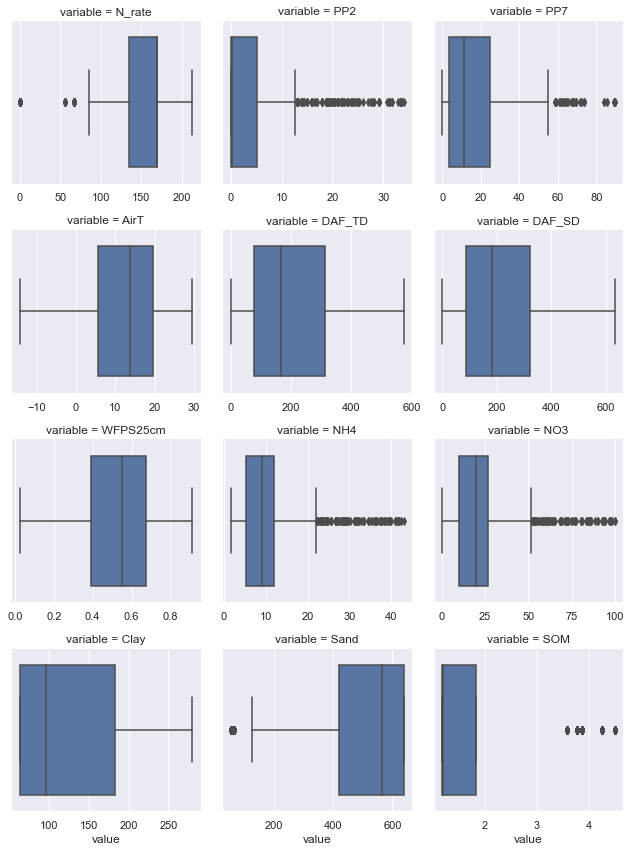

In [31]:
unpivot = pd.melt(agri_data_train_o, id_vars='N2O',value_vars=num_cols[2:])
g = sns.FacetGrid(unpivot, col='variable', col_wrap=3, sharex=False, sharey=False)
g.map(sns.boxplot,'value')
plt.show()

In [32]:
Q1 = agri_data_train[num_cols].quantile(0.25)
Q3 = agri_data_train[num_cols].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Year          3.000
N2O           4.385
N_rate       35.000
PP2           5.842
PP7          23.910
AirT         13.450
DAF_TD      240.000
DAF_SD      247.250
WFPS25cm      0.290
NH4           7.394
NO3          17.412
Clay        120.750
Sand        218.667
SOM           0.649
dtype: float64


In [33]:
agri_data_train_o2 = agri_data_train[num_cols][~((agri_data_train[num_cols] < (Q1 - 1.5 * IQR)) |(agri_data_train[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
agri_data_train_o2.shape

(709, 14)

In [34]:
agri_data_train_o2

,Year,N2O,N_rate,PP2,PP7,AirT,DAF_TD,DAF_SD,WFPS25cm,NH4,NO3,Clay,Sand,SOM
919,2016,-0.585,170,0.00,16.00,18.50,130,91,0.607,6.452,14.963,62.500,637.500,1.174
1823,2014,-0.760,167,0.00,7.11,17.87,71,42,0.219,22.237,11.728,169.833,418.833,1.823
833,2016,0.980,170,2.00,1.00,20.50,36,363,0.600,6.355,23.093,62.500,637.500,1.174
700,2016,2.704,170,0.00,29.00,-0.80,247,200,0.660,10.542,22.967,62.500,637.500,1.174
2210,2013,-2.320,91,0.00,0.00,18.13,6,6,0.293,23.688,39.218,162.500,490.375,1.496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,2012,4.846,170,9.91,9.91,-0.70,189,155,0.716,9.369,23.406,62.500,637.500,1.174
834,2016,4.782,170,13.00,3.00,22.90,37,364,0.639,5.974,21.327,62.500,637.500,1.174
1043,2017,-0.526,170,0.00,0.00,10.90,354,315,0.766,9.587,24.882,62.500,637.500,1.174
936,2016,8.838,170,3.00,24.00,18.30,151,112,0.749,9.383,17.204,62.500,637.500,1.174


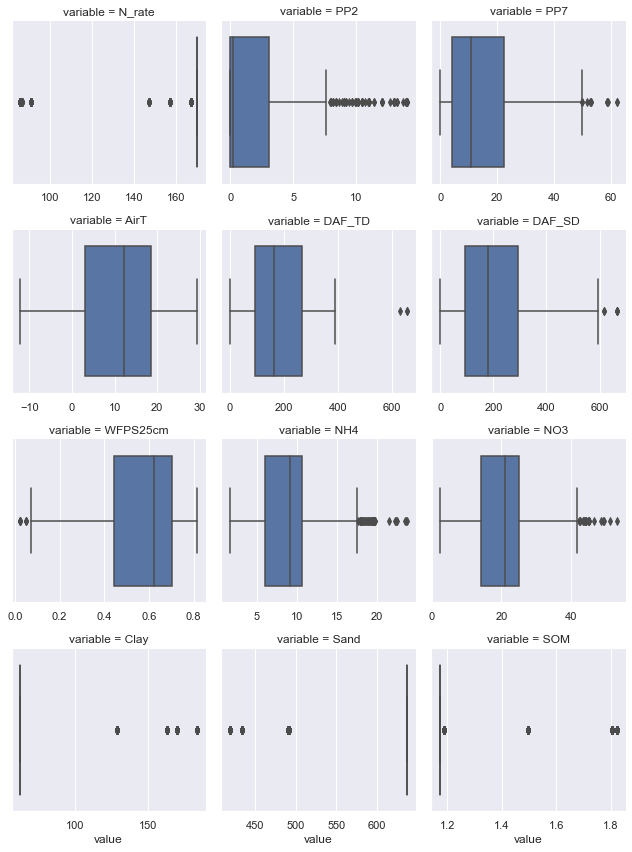

In [35]:
unpivot = pd.melt(agri_data_train_o2, id_vars='N2O',value_vars=num_cols[2:])
g = sns.FacetGrid(unpivot, col='variable', col_wrap=3, sharex=False, sharey=False)
g.map(sns.boxplot,'value')
plt.show()

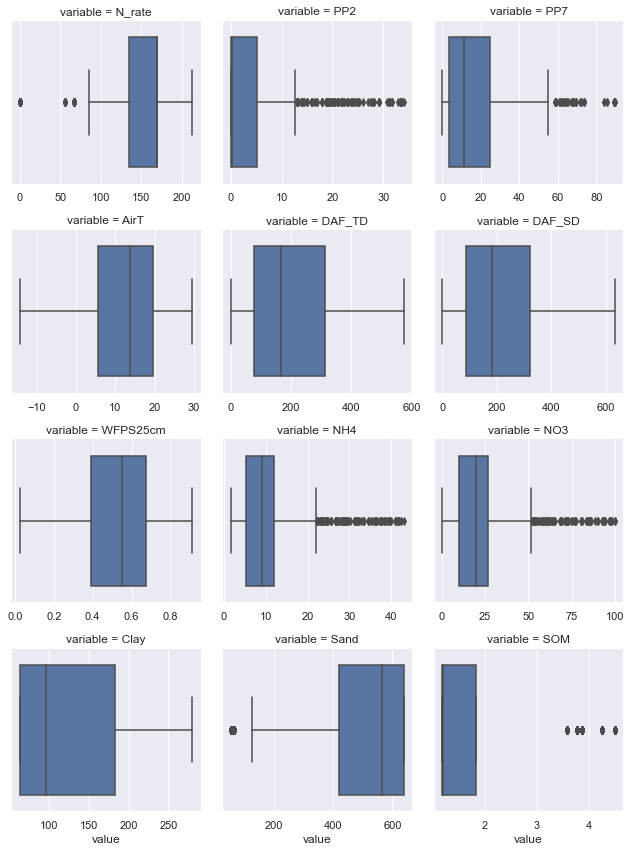

In [36]:
unpivot = pd.melt(agri_data_train_o, id_vars='N2O',value_vars=num_cols[2:])
g = sns.FacetGrid(unpivot, col='variable', col_wrap=3, sharex=False, sharey=False)
g.map(sns.boxplot,'value')
plt.show()

In [37]:
pos_skew = [col for col in agri_data_train_o[num_cols].columns if agri_data_train_o[col].skew() > 0]
neg_skew = [col for col in agri_data_train_o[num_cols].columns if agri_data_train_o[col].skew() < 0]
print('Positive Skew Columns: ',pos_skew)
print('Negative Skew Columns: ',neg_skew)    

Positive Skew Columns:  ['N2O', 'PP2', 'PP7', 'DAF_TD', 'DAF_SD', 'NH4', 'NO3', 'Clay', 'SOM']
Negative Skew Columns:  ['Year', 'N_rate', 'AirT', 'WFPS25cm', 'Sand']


In [38]:
agri_data_train_o.skew()

Year       -1.072
N2O         4.873
N_rate     -1.519
PP2         2.256
PP7         1.444
AirT       -0.532
DAF_TD      0.532
DAF_SD      0.248
WFPS25cm   -0.471
NH4         1.881
NO3         1.791
Clay        0.629
Sand       -1.081
SOM         1.452
dtype: float64

In [39]:
agri_data_train_o2.skew()

Year       -0.849
N2O         1.144
N_rate     -2.529
PP2         1.791
PP7         1.063
AirT       -0.399
DAF_TD      0.409
DAF_SD      0.543
WFPS25cm   -0.922
NH4         0.681
NO3         0.460
Clay        1.562
Sand       -1.541
SOM         2.235
dtype: float64

In [40]:
agri_data_train_o2.columns

Index(['Year', 'N2O', 'N_rate', 'PP2', 'PP7', 'AirT', 'DAF_TD', 'DAF_SD',
       'WFPS25cm', 'NH4', 'NO3', 'Clay', 'Sand', 'SOM'],
      dtype='object')

In [41]:
cat_cols = ['Experiment','Replication', 'Month', 'Vegetation']

In [42]:
agri_data_train['Experiment'] = agri_data_train['Experiment'].map({'Arlington WI':1,'BCSE_KBS':2,'MCSE-T2':3})
agri_data_test['Experiment']  = agri_data_test['Experiment'].map({'Arlington WI':1,'BCSE_KBS':2,'MCSE-T2':3})

In [43]:
agri_data_train['Replication'] = agri_data_train['Replication'].map({'R1':1, 'R2':2, 'R3':3, 'R4':4, 'R5':5})
agri_data_test['Replication'] = agri_data_test['Replication'].map({'R1':1, 'R2':2, 'R3':3, 'R4':4, 'R5':5})

In [44]:
agri_data_train['Month'] = agri_data_train['Month'].map({'September':9, 'July':7, 'June':6, 'January':1, 
                                     'May':5, 'December':12, 'February':2, 'October':10,
                                     'April':4, 'August':8, 'November':11, 'March':3})
agri_data_test['Month'] = agri_data_test['Month'].map({'September':9, 'July':7, 'June':6, 'January':1, 
                                     'May':5, 'December':12, 'February':2, 'October':10,
                                     'April':4, 'August':8, 'November':11, 'March':3})

In [45]:
agri_data_train['Vegetation'] = agri_data_train['Vegetation'].map({'Corn':1, 'TRIAE':2, 'GLYMX':3})
agri_data_test['Vegetation'] = agri_data_test['Vegetation'].map({'Corn':1, 'TRIAE':2, 'GLYMX':3})

In [46]:
agri_data_train['Vegetation'].value_counts()

1    1287
3     147
2     138
Name: Vegetation, dtype: int64

In [47]:
agri_data_train.head()

,Date,Year,Experiment,DataUse,Replication,Month,Vegetation,VegType,N2O,N_rate,PP2,PP7,AirT,DAF_TD,DAF_SD,WFPS25cm,NH4,NO3,Clay,Sand,SOM
919,2016-09-16,2016,2,Building,1,9,1,Annual,-0.585,170,0.0,16.00,18.50,130,91,0.607,6.452,14.963,62.500,637.500,1.174
1823,2014-07-30,2014,3,Testing,3,7,1,Annual,-0.760,167,0.0,7.11,17.87,71,42,0.219,22.237,11.728,169.833,418.833,1.823
833,2016-06-14,2016,2,Building,1,6,1,Annual,0.980,170,2.0,1.00,20.50,36,363,0.600,6.355,23.093,62.500,637.500,1.174
700,2016-01-03,2016,2,Building,1,1,1,Annual,2.704,170,0.0,29.00,-0.80,247,200,0.660,10.542,22.967,62.500,637.500,1.174
2210,2013-05-08,2013,3,Testing,1,5,2,Annual,-2.320,91,0.0,0.00,18.13,6,6,0.293,23.688,39.218,162.500,490.375,1.496


In [48]:
agri_data_train = agri_data_train.drop(['DataUse','VegType','Sand'], axis=1)
agri_data_test  = agri_data_test.drop(['DataUse','VegType','Sand'], axis=1)

In [49]:
agri_data_train = agri_data_train.drop('Replication', axis=1)
agri_data_test  = agri_data_test.drop('Replication', axis=1)

In [50]:
agri_data_train = agri_data_train.drop('Date', axis=1)
agri_data_test  = agri_data_test.drop('Date', axis=1)

In [51]:
agri_data_train.head()

,Year,Experiment,Month,Vegetation,N2O,N_rate,PP2,PP7,AirT,DAF_TD,DAF_SD,WFPS25cm,NH4,NO3,Clay,SOM
919,2016,2,9,1,-0.585,170,0.0,16.00,18.50,130,91,0.607,6.452,14.963,62.500,1.174
1823,2014,3,7,1,-0.760,167,0.0,7.11,17.87,71,42,0.219,22.237,11.728,169.833,1.823
833,2016,2,6,1,0.980,170,2.0,1.00,20.50,36,363,0.600,6.355,23.093,62.500,1.174
700,2016,2,1,1,2.704,170,0.0,29.00,-0.80,247,200,0.660,10.542,22.967,62.500,1.174
2210,2013,3,5,2,-2.320,91,0.0,0.00,18.13,6,6,0.293,23.688,39.218,162.500,1.496


In [52]:
data = pd.concat([agri_data_train,agri_data_test])
data.head()

,Year,Experiment,Month,Vegetation,N2O,N_rate,PP2,PP7,AirT,DAF_TD,DAF_SD,WFPS25cm,NH4,NO3,Clay,SOM
919,2016,2,9,1,-0.585,170,0.0,16.00,18.50,130,91,0.607,6.452,14.963,62.500,1.174
1823,2014,3,7,1,-0.760,167,0.0,7.11,17.87,71,42,0.219,22.237,11.728,169.833,1.823
833,2016,2,6,1,0.980,170,2.0,1.00,20.50,36,363,0.600,6.355,23.093,62.500,1.174
700,2016,2,1,1,2.704,170,0.0,29.00,-0.80,247,200,0.660,10.542,22.967,62.500,1.174
2210,2013,3,5,2,-2.320,91,0.0,0.00,18.13,6,6,0.293,23.688,39.218,162.500,1.496


In [53]:
data.to_csv("agri_data_v0_encoded.csv", index=False)
data.head()

,Year,Experiment,Month,Vegetation,N2O,N_rate,PP2,PP7,AirT,DAF_TD,DAF_SD,WFPS25cm,NH4,NO3,Clay,SOM
919,2016,2,9,1,-0.585,170,0.0,16.00,18.50,130,91,0.607,6.452,14.963,62.500,1.174
1823,2014,3,7,1,-0.760,167,0.0,7.11,17.87,71,42,0.219,22.237,11.728,169.833,1.823
833,2016,2,6,1,0.980,170,2.0,1.00,20.50,36,363,0.600,6.355,23.093,62.500,1.174
700,2016,2,1,1,2.704,170,0.0,29.00,-0.80,247,200,0.660,10.542,22.967,62.500,1.174
2210,2013,3,5,2,-2.320,91,0.0,0.00,18.13,6,6,0.293,23.688,39.218,162.500,1.496


In [54]:
def modelling(X_train, y_train, X_test, y_test, **kwargs):
    scores = {}
    models = []
    if 'xgb' in kwargs.keys() and kwargs['xgb']:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        scores['xgb'] = r2_score(y_test, y_pred)
        
    if 'rf' in kwargs.keys() and kwargs['rf']:
        rf = RandomForestRegressor(n_estimators=200, criterion='mse')
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        scores['rf'] = r2_score(y_test, y_pred)
        models.append(rf)

    if 'dtree' in kwargs.keys() and kwargs['dtree']:
        dtree = DecisionTreeRegressor(criterion='mse')
        dtree.fit(X_train, y_train)
        y_pred = dtree.predict(X_test)
        scores['dtree'] = r2_score(y_test, y_pred)
        models.append(dtree)
        
    return scores

In [55]:
X_train = agri_data_train.drop('N2O',axis=1)
y_train = agri_data_train['N2O']
X_test = agri_data_test.drop('N2O',axis=1)
y_test = agri_data_test['N2O']

In [56]:
modelling(X_train, y_train, X_test, y_test, xgb=True, rf=True, dtree=True)

{'xgb': -0.05498341650321126,
 'rf': 0.34203231316563487,
 'dtree': 0.4058403836971586}

In [57]:
agri_data_train['Vegetation'].value_counts(normalize=True)

1    0.819
3    0.094
2    0.088
Name: Vegetation, dtype: float64

In [58]:
major = agri_data_train.drop(["Vegetation"], axis=1)
minor = agri_data_train["Vegetation"]

counter = Counter(minor)

for k,v in counter.items():
	per = v / len(minor) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=1, n=1287 (81.870%)
Class=2, n=138 (8.779%)
Class=3, n=147 (9.351%)


In [59]:
oversample = SMOTE()
major, minor = oversample.fit_resample(major, minor)
# summarize distribution
counter = Counter(minor)
for k,v in counter.items():
    per = v / len(minor) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=1, n=1287 (33.333%)
Class=2, n=1287 (33.333%)
Class=3, n=1287 (33.333%)


In [60]:
agri_data_train_balanced = pd.concat([major,minor], axis=1)
agri_data_train_balanced

,Year,Experiment,Month,N2O,N_rate,PP2,PP7,AirT,DAF_TD,DAF_SD,WFPS25cm,NH4,NO3,Clay,SOM,Vegetation
0,2016,2,9,-0.585,170,0.000,16.000,18.500,130,91,0.607,6.452,14.963,62.500,1.174,1
1,2014,3,7,-0.760,167,0.000,7.110,17.870,71,42,0.219,22.237,11.728,169.833,1.823,1
2,2016,2,6,0.980,170,2.000,1.000,20.500,36,363,0.600,6.355,23.093,62.500,1.174,1
3,2016,2,1,2.704,170,0.000,29.000,-0.800,247,200,0.660,10.542,22.967,62.500,1.174,1
4,2013,3,5,-2.320,91,0.000,0.000,18.130,6,6,0.293,23.688,39.218,162.500,1.496,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3856,2006,3,9,1.582,0,1.290,18.534,9.734,504,465,0.363,5.313,3.771,162.500,1.496,3
3857,2003,3,3,0.020,0,0.361,5.771,3.024,325,273,0.411,3.557,17.134,182.560,1.220,3
3858,2005,3,7,3.129,0,3.852,12.565,27.150,446,402,0.210,7.324,17.730,169.833,1.823,3
3859,2012,3,4,1.441,0,1.072,7.126,14.293,369,329,0.443,9.967,6.959,128.333,1.806,3


In [61]:
X = agri_data_train_balanced.drop("N2O", axis=1)
y = agri_data_train_balanced["N2O"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=19)

r2 score for base model: 0.791787


<AxesSubplot:>

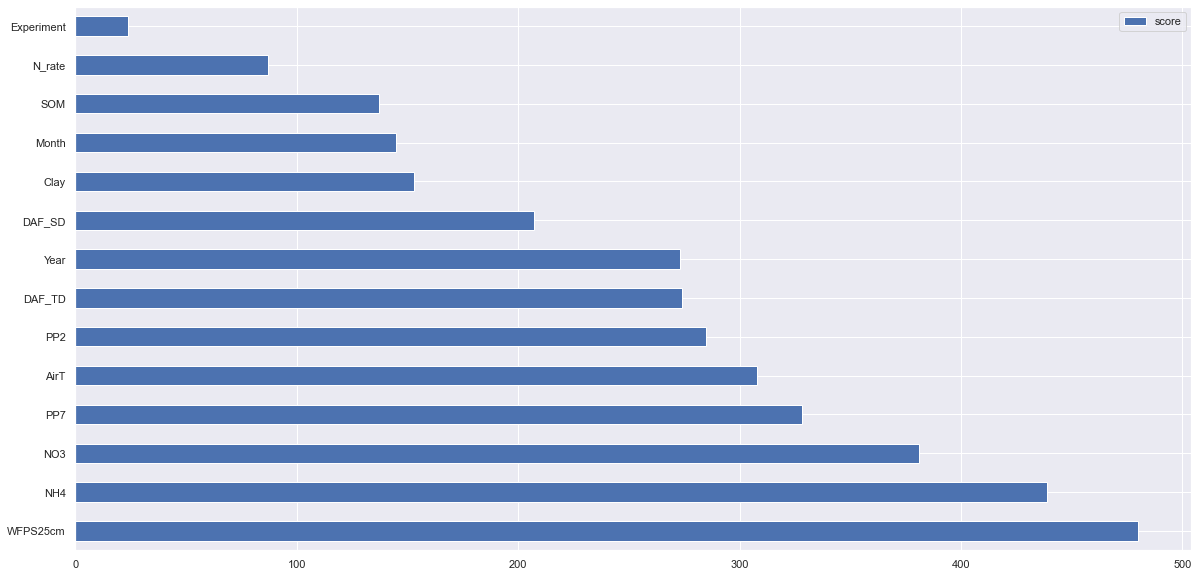

In [62]:
boost = XGBRegressor()
boost.fit(X_train, y_train)
y_pred = boost.predict(X_test)
print("r2 score for base model: %f" % r2_score(y_test, y_pred))

feature_important = boost.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh', figsize = (20,10))

In [63]:
modelling(X_train, y_train, X_test, y_test, xgb=True, rf=True, dtree=True)

{'xgb': 0.791787155872403,
 'rf': 0.736124609557731,
 'dtree': 0.34008345025145215}

In [64]:
def select_features_corr_based(X_train, y_train, X_test, x="all"):
    if type(x) == str:
        fs_corr = SelectKBest(score_func=f_regression, k='all')
    else:
        fs_corr = SelectKBest(score_func=f_regression, k = x)
    fs_corr.fit(X_train, y_train)
    X_train_fs = fs_corr.transform(X_train)
    X_test_fs = fs_corr.transform(X_test)
    
    return X_train_fs, X_test_fs, fs_corr


def fs_score_plot(fs_func):
    
    for i in range(len(fs_func.scores_)):
        print('Feature %d: %f' % (i, fs_func.scores_[i]))
    # plot the scores
    x = [i for i in range(len(fs_func.scores_))]
    y = fs_func.scores_
    plt.bar(x, y)
    plt.xticks(x, X_train.columns.to_list(), fontsize=12, rotation=90)
    plt.show()

def select_features_model_based(estimator, X_train, y_train, X_test, n=None):
    
    rfe = RFE(estimator=estimator, n_features_to_select=n)
    rfe.fit(X_train,y_train)
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)
    
    return X_train_rfe, X_test_rfe, rfe

def rfe_score_plot(rfe):

    plt.figure(figsize=(7,5))
    sns.barplot(y =X_train.columns, x = max(rfe.ranking_) - rfe.ranking_)
    plt.show()

Feature 0: 14.602650
Feature 1: 118.497599
Feature 2: 2.357063
Feature 3: 52.674513
Feature 4: 57.214982
Feature 5: 61.531804
Feature 6: 16.186105
Feature 7: 45.913721
Feature 8: 48.304304
Feature 9: 102.423608
Feature 10: 797.159109
Feature 11: 352.888583
Feature 12: 23.647174
Feature 13: 113.721883
Feature 14: 49.605450


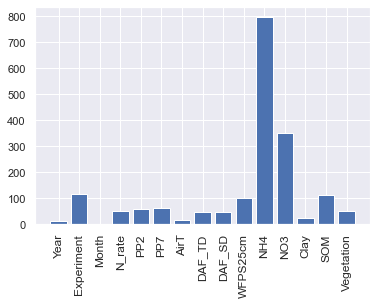

array([ 0.17054882, -2.12393037,  0.23323221])

In [65]:
X_train_fs, X_test_fs, fs_ = select_features_corr_based(X_train, y_train, X_test, x=7)
fs_score_plot(fs_)

cv = cross_val_score(XGBRegressor(), X_train_fs, y_train, scoring='r2', cv=3, n_jobs=-1)
cv

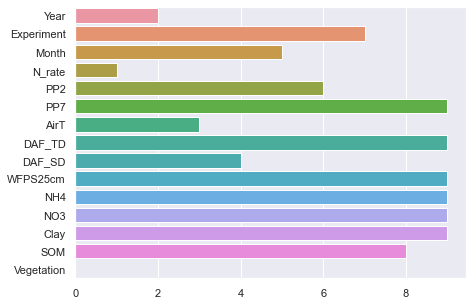

array([ 0.10995056, -2.02306819,  0.27697603])

In [66]:
X_train_rfe, X_test_rfe, rfe_ = select_features_model_based(XGBRegressor(), X_train, y_train, X_test, n=6)
plt.figure(figsize=(7,5))
sns.barplot(y =X_train.columns, x = max(rfe_.ranking_) - rfe_.ranking_)
plt.show()

cv = cross_val_score(XGBRegressor(), X_train_rfe, y_train, scoring='r2', cv=3, n_jobs=-1)
cv

In [67]:
print(modelling(X_train_fs, y_train, X_test_fs, y_test, xgb=True, rf=True, dtree=True))
print(modelling(X_train_rfe, y_train, X_test_rfe, y_test, xgb=True, rf=True, dtree=True))

{'xgb': 0.5582455106525546, 'rf': 0.7455411953930947, 'dtree': -0.04175649512017787}
{'xgb': 0.7398145852685298, 'rf': 0.7328041541636641, 'dtree': 0.09018032552149313}


In [69]:
data.index

Index(['WFPS25cm', 'NH4', 'NO3', 'PP7', 'AirT', 'PP2', 'DAF_TD', 'Year',
       'DAF_SD', 'Clay', 'Month', 'SOM', 'N_rate', 'Experiment'],
      dtype='object')

In [71]:
feats = data.index.to_list()
feats

['WFPS25cm',
 'NH4',
 'NO3',
 'PP7',
 'AirT',
 'PP2',
 'DAF_TD',
 'Year',
 'DAF_SD',
 'Clay',
 'Month',
 'SOM',
 'N_rate',
 'Experiment']

In [72]:
X_train_sel = X_train[feats]
x_test_sel = X_test[feats]

cv = RepeatedKFold(n_splits= 78, n_repeats = 3, random_state = 1)

grid_params_xgb = [{ 'n_estimators': [100, 200],
                   'model__max_depth': [9,12],
                   'model__min_child_weight': [7,8],
                   'model__subsample': [i/10 for i in range(9,11)]
                    }]

XGB = GridSearchCV(estimator=boost,
            param_grid=grid_params_xgb,
            scoring='r2',
            cv=cv, 
            n_jobs= -1,
            verbose=10)


XGB.fit(X_train_sel, y_train)


Fitting 234 folds for each of 16 candidates, totalling 3744 fits
[21:10:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "model__max_depth", "model__min_child_weight", "model__subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=78, random_state=1),
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=4,
                                    num_parallel_tree=1, random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_parameters=1,
     

In [73]:
print('Best MAE: %.3f' % XGB.best_score_) # model__max_depth=12, model__min_child_weight=8, model__subsample=1.0, n_estimators=200
boost_final = XGB.best_estimator_

Best MAE: -1.570


In [77]:
X_test.shape

(1275, 15)

In [78]:
y_test.shape

(1275,)

In [83]:
X_test.shape[0]

1275

In [82]:
boost_final.predict(X_test)

ValueError: Feature shape mismatch, expected: 14, got 1275

In [80]:
y_hat = boost_final.predict(X_test)

ValueError: Feature shape mismatch, expected: 14, got 1275

In [76]:
y_hat = boost_final.predict(X_test)
# print(f'Training score : {XGB.score(X_test,y_test)}')

print()
print('r2 score:', r2_score(y_test, y_hat))
print('MAE:', mean_absolute_error(y_test, y_hat))
print('MSE:', mean_squared_error(y_test, y_hat))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_hat)))

ValueError: Feature shape mismatch, expected: 14, got 1275

In [127]:
plt.figure(figsize = (7,5))
sns.set()
sns.distplot(y_test - y_hat)
plt.title("Error Rate Distribution");

NameError: name 'y_hat' is not defined

<Figure size 504x360 with 0 Axes>

In [84]:
import joblib

with open('./boost_final.pkl.compressed', 'wb') as m:
    joblib.dump(boost_final, m, compress=3)